In [1]:
import os
import json


In [2]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

In [3]:
from utils import read_features, read_targets, scale_feature_set, d_types_methods, reduce_components, \
    print_info_features, combine_features_all_txt_img, metrics_c, evaluate, plot_confusion_matrix

## Read Features and Targets


In [4]:
path = os.path.abspath(os.path.join(os.getcwd(), "../../data/chronology_prediction"))

In [5]:
X = read_features(path)
y = read_targets(path, ["HistoricalPeriod"])

Loaded X_train_tfidf
Loaded X_train_bert
Loaded X_train_cannyhog
Loaded X_train_resnet
Loaded X_train_vit
Loaded X_test_tfidf
Loaded X_test_bert
Loaded X_test_cannyhog
Loaded X_test_resnet
Loaded X_test_vit
Loaded y_train
Loaded y_test


## Scale Features

In [6]:
X = {
    subset: {
        method: scale_feature_set(_X) if method != "tfidf" else _X
        for method, _X in X[subset].items()
    } for subset in X.keys()
}

## Reduce Features

Use n_components=0.95 to keep enough components to preserve 95% of the variance in the data.

In [7]:
reducers = {}
X_reduced = {subset: {} for subset in X.keys()}
for method in d_types_methods["text"] + d_types_methods["image"]:
    if method == "tfidf":
        for subset in X.keys(): X_reduced[subset][method] = X[subset][method]
        continue

    X_reduced["train"][method], reducers[method] = reduce_components(X["train"][method], n_components=0.95)

    X_reduced["test"][method], _ = reduce_components(X["test"][method], reducer_fitted=reducers[method])

In [8]:
print_info_features(X)

X = {
	train: {
		tfidf: 
			<class 'pandas.core.frame.DataFrame'>
			shape = (1719, 300), 
		bert: 
			<class 'pandas.core.frame.DataFrame'>
			shape = (1719, 768), 
		cannyhog: 
			<class 'pandas.core.frame.DataFrame'>
			shape = (1719, 2917), 
		resnet: 
			<class 'pandas.core.frame.DataFrame'>
			shape = (1719, 2048), 
		vit: 
			<class 'pandas.core.frame.DataFrame'>
			shape = (1719, 768), 
	},
	test: {
		tfidf: 
			<class 'pandas.core.frame.DataFrame'>
			shape = (191, 300), 
		bert: 
			<class 'pandas.core.frame.DataFrame'>
			shape = (191, 768), 
		cannyhog: 
			<class 'pandas.core.frame.DataFrame'>
			shape = (191, 2917), 
		resnet: 
			<class 'pandas.core.frame.DataFrame'>
			shape = (191, 2048), 
		vit: 
			<class 'pandas.core.frame.DataFrame'>
			shape = (191, 768), 
	},
}


## Combine & Re-scale Text & Image Feature Sets

In [9]:
for subset in X.keys():
    X[subset].update(combine_features_all_txt_img(X[subset], scale=True))
    X_reduced[subset].update(combine_features_all_txt_img(X_reduced[subset], scale=True))

## Encode Target Labels

In [10]:
le = LabelEncoder()

y["train"]["HistoricalPeriod_encoded"] = le.fit_transform(y["train"]["HistoricalPeriod"])
y["test"]["HistoricalPeriod_encoded"] = le.transform(y["test"]["HistoricalPeriod"])

label_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
for label, encoding in label_mapping.items():
    print(f"{encoding} --> {label}")

0 --> Archaic
1 --> Classical
2 --> Hellenistic
3 --> Orientalizing


In [11]:
target = "HistoricalPeriod_encoded"

## Load Best Parameters from HP Tuning

In [12]:
path_params = "best_params.json"
with open(path_params, "r") as f:
    best_params = json.load(f)
    best_params = {
        model: {
            eval(k): v for k, v in param_dict.items()
        } for model, param_dict in best_params.items()
    }

## Text --> HistoricalPeriod

In [13]:
model_class = XGBClassifier
model_name = 'XGBoost'
features = "tfidf"

model = model_class(**best_params[model_name][(features, target)])
model.fit(X_reduced["train"][features], y["train"][target])
y_pred = model.predict(X_reduced["test"][features])

C:\Users\dimit\.conda\envs\thesis\Lib\site-packages\xgboost\core.py:705: UserWarning: [00:12:46] WARNING: D:\bld\xgboost-split_1748292846627\work\src\common\error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)


In [14]:
scores = evaluate(y["test"][target], y_pred, metrics_c)
scores

{'accuracy': 0.7801047120418848,
 'precision': 0.5120071105365223,
 'recall': 0.5362990702479339,
 'f1': 0.5229915433403806}

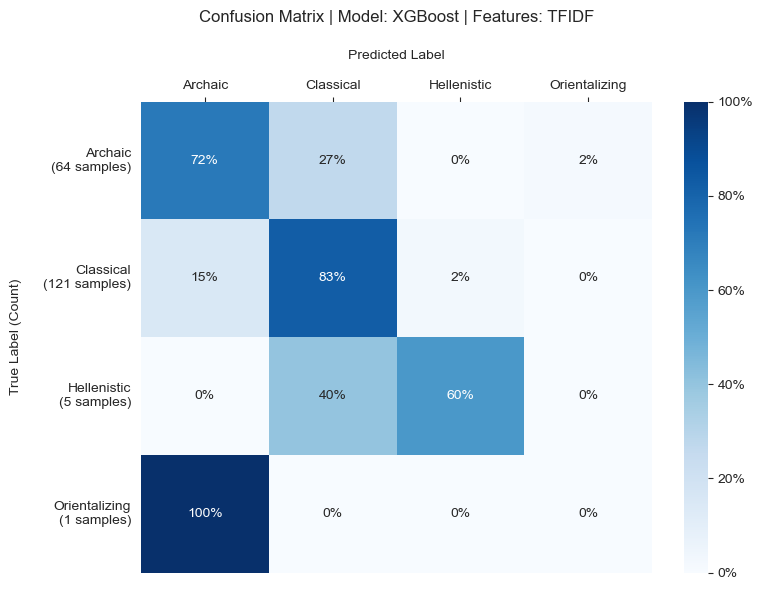

In [15]:
cm = confusion_matrix(y["test"][target], y_pred)
plot_confusion_matrix(cm, le, model_name, features)

## Image --> HistoricalPeriod

In [16]:
model_class = LogisticRegression
model_name = 'LogisticRegression'
features = "vit"

model = model_class(**best_params[model_name][(features, target)])
model.fit(X["train"][features], y["train"][target])
y_pred = model.predict(X["test"][features])

In [17]:
scores = evaluate(y["test"][target], y_pred, metrics_c)
scores

{'accuracy': 0.7591623036649214,
 'precision': 0.5717792792792793,
 'recall': 0.49675232438016526,
 'f1': 0.5187181079731589}

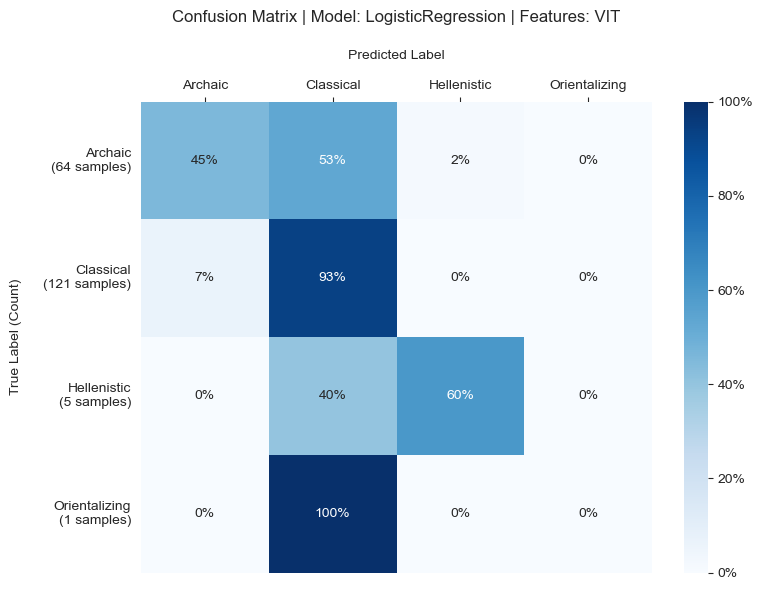

In [18]:
cm = confusion_matrix(y["test"][target], y_pred)
plot_confusion_matrix(cm, le, model_name, features)

## Text + Image Combo --> HistoricalPeriod

In [19]:
model_class = LogisticRegression
model_name = 'LogisticRegression'
features = "tfidf + vit"

model = model_class(**best_params[model_name][(features, target)])
model.fit(X["train"][features], y["train"][target])
y_pred = model.predict(X["test"][features])

In [20]:
scores = evaluate(y["test"][target], y_pred, metrics_c)
scores

{'accuracy': 0.806282722513089,
 'precision': 0.6419143949673122,
 'recall': 0.5503099173553719,
 'f1': 0.5835160242256009}

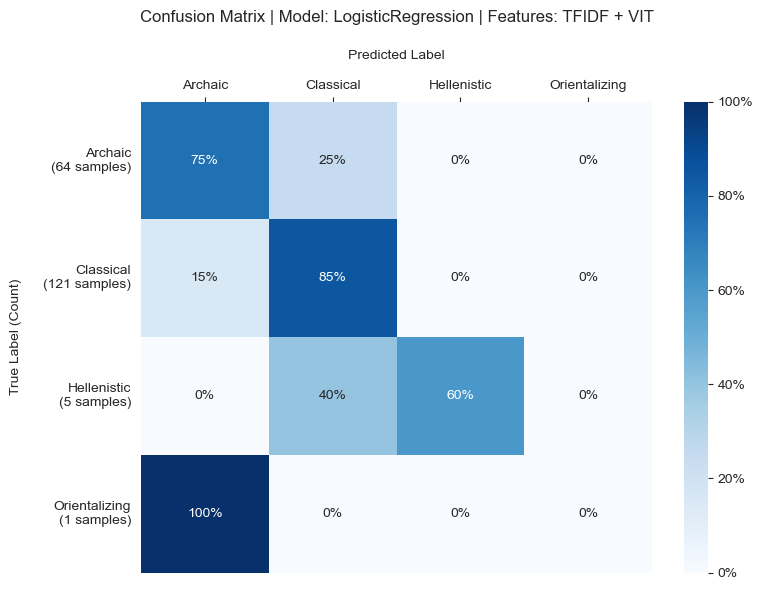

In [21]:
cm = confusion_matrix(y["test"][target], y_pred)
plot_confusion_matrix(cm, le, model_name, features)